First we import the modules necessary for the project.

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import db_utils as du

c:\Users\srayn\EDA-manufacturing\db_utils.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_temp_nulls['Process temperature [K]'] = np.round(process_temp_gradient * process_temp_nulls['Air temperature [K]'] + process_temp_intercept, 1)
c:\Users\srayn\EDA-manufacturing\db_utils.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_temp_nulls['Air temperature [K]'] = np.round(air_temp_gradient * air_temp_nulls['Process temperature [K]'] + air_temp_intercept, 1)
c:\Users\srayn\EDA-manufacturing

## Extracting and cleaning the data

We use class methods from the db_utils.py file to clean and analyse our data.

First we download the data from the RDS database, save it to the local machine, and upload it into a dataframe.

In [2]:
dc = du.RDSDatabaseConnector('credentials.yaml')
df = dc.read_rds_table(table='failure_data')
dc.save_data('failure_data', 'failure_data.csv')
df = du.RDSDatabaseConnector.load_data('failure_data.csv')


We can now view the dataframe and check column types.

In [3]:
display(df.head(10))
print(df.info())

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,3416,L50595,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0
1,7130,L54309,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0
2,2320,M17179,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0
3,9601,M24460,M,298.9,310.0,1561,45.3,58.0,0,0,0,0,0,0
4,614,L47793,L,298.1,309.9,1634,30.0,53.0,0,0,0,0,0,0
5,4602,M19461,M,303.0,311.1,1372,54.3,117.0,1,0,1,0,0,0
6,5247,L52426,L,NaN,NaN,1465,41.0,56.0,0,0,0,0,0,0
7,7008,L54187,L,300.5,310.6,1499,45.2,8.0,0,0,0,0,0,0
8,9375,M24234,M,297.8,308.5,1466,44.7,88.0,0,0,0,0,0,0
9,1962,L49141,L,297.8,NaN,1448,51.2,107.0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      9162 non-null   float64
 4   Process temperature [K]  9119 non-null   float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          9516 non-null   float64
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(4), int64(8)

We check the formats of the entries in the columns, to check for invalid or erroneous values. We can conclude from the following lines of code:

- The 'UDI' column contains exactly all the integers from 1 to 10000.
- The 'Product ID' column entries are all of the format of one capital letter followed by 5 digits.
- The 'Type' column takes values 'L', 'M' and 'H' only.
- 'Air temperature', 'Process temperature', 'Rotational speed', 'Torque' and 'Tool wear' are within expected ranges, so do not contain any erroneous values.
- Machine failure, TWF, HDF, PWF, OSF and RNF are boolean variables.


In [4]:
print(len(set(df['UDI']) & set(range(1, 10001))))

print(len(df[df['Product ID'].str.contains(r'^[A-Z]\d{5}$') == False]))

print(df['Type'].value_counts())

print(df['Air temperature [K]'].describe()) # Similarly for process temperature, rotational speed, torque and tool wear.

print(df['Machine failure'].value_counts()) # Similarly for TWF, HDF, PWF, OSF, RNF.

10000
0
L    6000
M    2997
H    1003
Name: Type, dtype: int64
count    9162.000000
mean      300.008590
std         1.999148
min       295.300000
25%       298.300000
50%       300.100000
75%       301.500000
max       304.500000
Name: Air temperature [K], dtype: float64
0    9661
1     339
Name: Machine failure, dtype: int64


As all columns are clean (except for null values), there is not much cleaning to do. The only thing we do in our cleaning function is therefore to convert the 'Type' column to the 'category' data type.

In [5]:
dt = du.DataTransform
df = dt.cleaning(df)

## Preparing the data

To investigate how best we can impute the null values, we will check the correlation heatmap.

In [6]:
px.imshow(df.corr(), title="Correlation heatmap of dataframe")

C:\Users\srayn\AppData\Local\Temp\ipykernel_2788\2245194622.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  px.imshow(df.corr(), title="Correlation heatmap of dataframe")


From this heatmap, we can see that 'Air temperature \[K\]' and 'Process temperature \[K\]' are strongly positively correlated (0.87) while 'Rotational speed \[rpm\]' and 'Torque \[Nm\]' are strongly negatively correlated (-0.88)

It would be good to see if we can impute the null values of Air temperature using the values of Process temperature and vice versa. This would only be possible where the null values of Air temperature do not align with the null values of Process temperature.

We can check how many records out of the 838 missing Air temperature and 881 missing Process temperature are missing both values.

In [7]:
air_temp_nulls = df['Air temperature [K]'].isnull()
process_temp_nulls = df['Process temperature [K]'].isnull()

print(len(df[air_temp_nulls & process_temp_nulls]))

79


From this, we know that 91% of Air temperature values and Process temperature values can be imputed using linear regression.

For the 79 records that are missing both Air and Process temperature values, as well as for 'Tool wear \[min\]', we will impute either with the median or the mean. We will calculate the skew of each variable to help us decide which statistic to use.

In [8]:
print(df.skew())

UDI                         0.000000
Air temperature [K]         0.118541
Process temperature [K]     0.006529
Rotational speed [rpm]      1.993171
Torque [Nm]                -0.009517
Tool wear [min]             0.021183
Machine failure             5.151852
TWF                        14.644462
HDF                         9.164789
PWF                        10.114516
OSF                         9.953916
RNF                        22.879570
dtype: float64


C:\Users\srayn\AppData\Local\Temp\ipykernel_2788\1926848427.py:1: FutureWarning:

The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



As the three columns we are imputing are not significantly skewed (skew < 0.5), we will impute Tool wear and the 79 records missing both Air and Process temperatures using the mean.

In [9]:
df = du.DataTransform.impute_nulls(df)

c:\Users\srayn\EDA-manufacturing\db_utils.py:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\srayn\EDA-manufacturing\db_utils.py:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\srayn\EDA-manufacturing\db_utils.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Now looking back at the skew of our variables, we need to transform 'Rotational speed \[rpm\]' to reduce its skew to an insignificant amount. We find that the log transform is insufficient for this, so we use a Box-Cox transform.

It is not necessary to transform the boolean variables, as nothing useful can be gained from that.

In [10]:
df = dt.remove_skew(df)
print(df.skew())

UDI                         0.000127
Air temperature [K]         0.112156
Process temperature [K]     0.017352
Rotational speed [rpm]      0.000000
Torque [Nm]                -0.009242
Tool wear [min]             0.021232
Machine failure             5.154597
TWF                        14.585709
HDF                         9.168607
PWF                        10.128333
OSF                         9.965855
RNF                        23.416539
dtype: float64


C:\Users\srayn\AppData\Local\Temp\ipykernel_12892\3617743142.py:2: FutureWarning:

The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Next, we check for outliers, which we visualise for each variable using a boxplot.

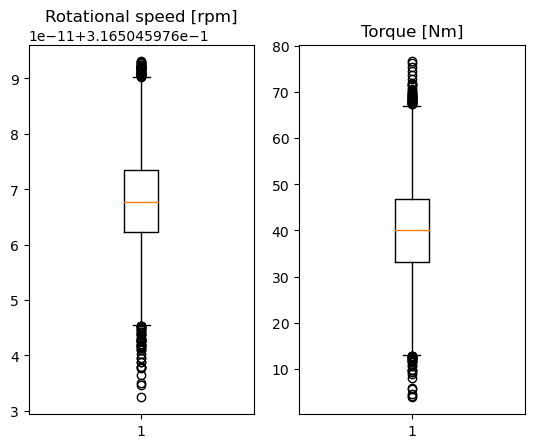

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
ax1.boxplot(df['Rotational speed [rpm]'])
ax1.set_title('Rotational speed [rpm]')
ax2.boxplot(df['Torque [Nm]'])
ax2.set_title('Torque [Nm]')
plt.show()

We find outliers in the 'Rotational speed \[rpm\]' and 'Torque \[Nm\]' columns. Outliers more than 3 standard deviations from the mean are dropped.

In [12]:
df = dt.drop_outliers(df, 'Rotational speed [rpm]')
df = dt.drop_outliers(df, 'Torque [Nm]')

c:\Users\srayn\EDA-manufacturing\db_utils.py:138: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\srayn\EDA-manufacturing\db_utils.py:138: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We next consider collinearity. We will look at collinearity between our explanatory variables; 'Air temperature \[K\]', 'Process temperature \[K\]', 'Rotational speed \[rpm\]', 'Torque \[Nm\]' and 'Tool wear \[min\]'.

To do this, we will use the statsmodels.formula.api module. First, we alter the column names to replace spaces and brackets with underscores. This is so that they can be used in the OLS (ordinary least squares) method. From the OLS method, we print the R^2 values which measure collinearity.

In [13]:
df.rename(columns={'Air temperature [K]': 'Air_temperature_K', 'Process temperature [K]': 'Process_temperature_K', 'Rotational speed [rpm]': 'Rotational_speed_rpm', 'Torque [Nm]': 'Torque_Nm', 'Tool wear [min]': 'Tool_wear_min'}, inplace=True)

model0 = smf.ols('Air_temperature_K ~ Process_temperature_K + Rotational_speed_rpm + Torque_Nm + Tool_wear_min', df).fit()
model1 = smf.ols('Process_temperature_K ~ Air_temperature_K + Rotational_speed_rpm + Torque_Nm + Tool_wear_min', df).fit()
model2 = smf.ols('Rotational_speed_rpm ~ Air_temperature_K + Process_temperature_K + Torque_Nm + Tool_wear_min', df).fit()
model3 = smf.ols('Torque_Nm ~ Air_temperature_K + Process_temperature_K + Rotational_speed_rpm + Tool_wear_min', df).fit()
model4 = smf.ols('Tool_wear_min ~ Air_temperature_K + Process_temperature_K + Rotational_speed_rpm + Torque_Nm', df).fit()

print(model0.rsquared, model1.rsquared, model2.rsquared, model3.rsquared, model4.rsquared)

0.7950725372867596 0.7950273582502619 0.8412879723527826 0.841261385204801 0.0003928879988955858


We will drop columns that appear to show too much collinearity with another column. We will use the 'Variation Inflation Factor' (VIF) as a metric, and the condition that VIF > 5 implies that columns should be dropped.

VIF can be calculated from the R^2 values by the equation:

```
VIF = 1/(1-R^2)
```

R^2 = 0.84 gives VIF = 6.25. The other R^2 values do not meet the VIF > 5 threshold.
This means 'Rotational speed \[rpm\]' and 'Torque \[Nm\]' are strongly collinear with other variables. It would make sense that these two variables are related as they are both mechanical quantities that have mathematical relationships linking them together.

We remove Rotational speed (therefore removing 'model2') from the OLS functions and recalculate the R^2 values.

In [14]:
model0 = smf.ols('Air_temperature_K ~ Process_temperature_K + Rotational_speed_rpm + Torque_Nm + Tool_wear_min', df).fit()
model1 = smf.ols('Process_temperature_K ~ Air_temperature_K + Torque_Nm + Tool_wear_min', df).fit()

model3 = smf.ols('Torque_Nm ~ Air_temperature_K + Process_temperature_K + Tool_wear_min', df).fit()
model4 = smf.ols('Tool_wear_min ~ Air_temperature_K + Process_temperature_K + Torque_Nm', df).fit()

print(model0.rsquared, model1.rsquared, model3.rsquared, model4.rsquared)

0.7950725372867596 0.7950256797425933 0.00023494200643958685 0.00038604395116326184


This reduces the R^2 value for Torque drastically, so now we don't have any collinearity issues with our columns. We will drop the 'Rotational speed \[rpm\]' from the dataframe.

In [15]:
df.rename(columns={"Air_temperature_K": "Air temperature [K]", "Process_temperature_K": "Process temperature [K]", 'Rotational_speed_rpm': 'Rotational speed [rpm]', 'Torque_Nm': 'Torque [Nm]', 'Tool_wear_min': 'Tool wear [min]'}, inplace=True)

df = dt.remove_collinearity(df)

We have now finished cleaning and transforming the data ready for analysis.

## Analysing the data

We will begin our analysis by calculating the current operating ranges of the machine. 

In [16]:
du.DataAnalysis.ranges_table(df)

Air_temp        Process_temp        Torque       Tool_wear     
            Max    Min          Max    Min    Max   Min       Max  Min
All       304.5  295.2        313.8  305.7   69.6  10.7     253.0  0.0
High      304.2  295.5        313.5  305.9   68.6  12.8     246.0  0.0
Medium    304.4  295.2        313.8  305.7   69.0  10.7     253.0  0.0
Low       304.5  295.3        313.8  305.7   69.6  11.8     251.0  0.0

This table shows the minimum and maximum values of the explanatory variables that the machine has been operating at.

We next investigate the machine failures. We calculate the number and percentage of failures, as well as visualise the numbers of failures for each product type, and the number of each type of failure.

Number of failures = 306 
Percentage of failures = 3.09967585089141


c:\Users\srayn\EDA-manufacturing\db_utils.py:271: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

c:\Users\srayn\EDA-manufacturing\db_utils.py:272: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

c:\Users\srayn\EDA-manufacturing\db_utils.py:273: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



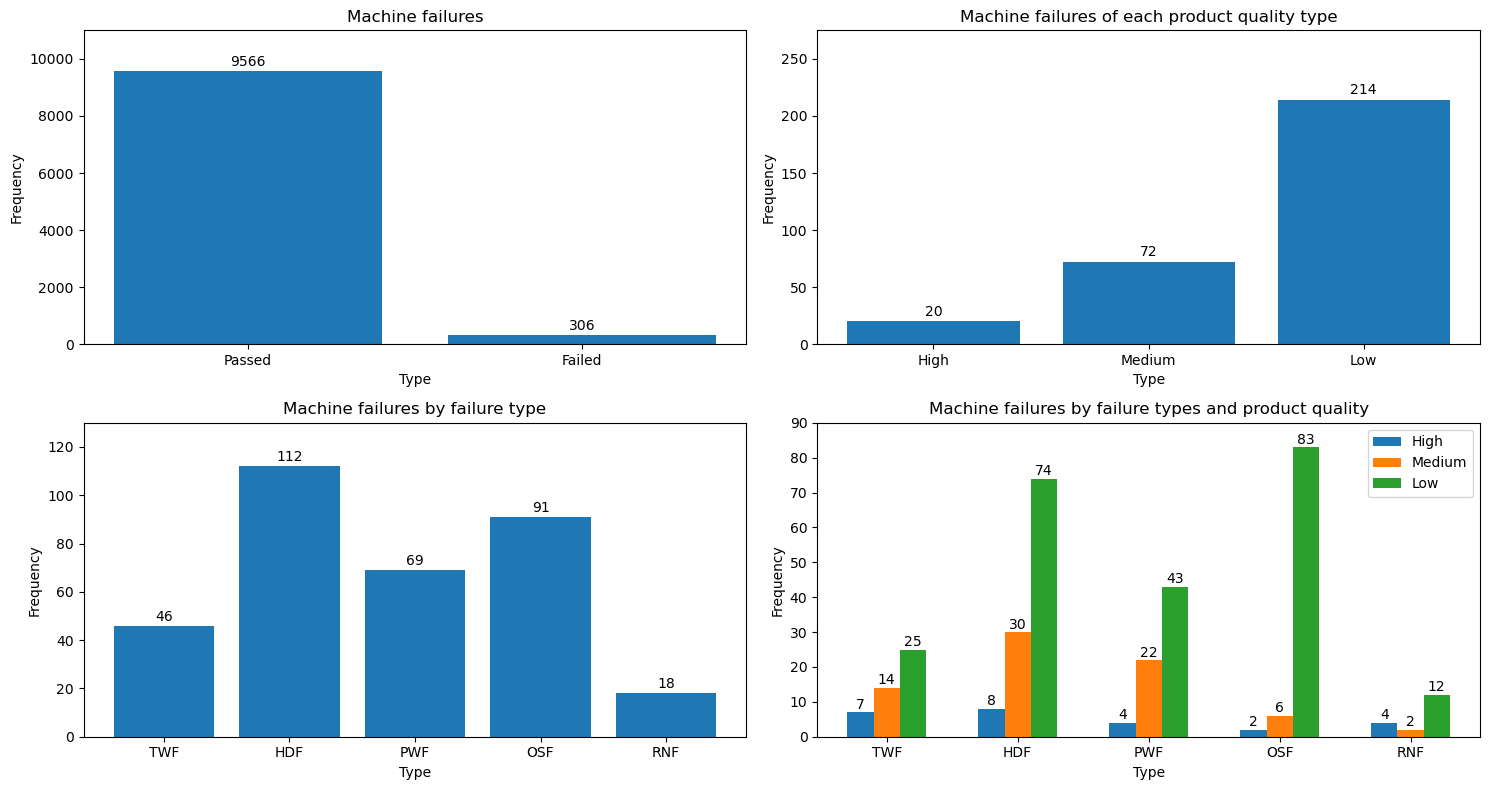

In [17]:
du.DataAnalysis.failure_plots(df)

The top-right graph here shows that the lower the quality of the product, the larger the chance of machine failure. In the bottom-left graph we can see the relative frequencies of the different types of machine failure. Overheating the machine and over-straining its parts are most often the cause.

The bottom-right graph shows that for all types of failure, low quality products cause the most. Tihs is most extreme in the case of OSF, which is caused by low quality products 91% of the time. So although OSF is the second most frequent cause of failure, it is disproportionately caused by low quality products.

We next examine any correlations between our explanatory variables (Air and Process temperatures, Torque, Tool wear) and the types of failures.

To do this, we plot histograms of the relative frequencies of failure types superimposed with the relative frequencies of explanatory variables. We only show the histograms that we can draw conclusions from.

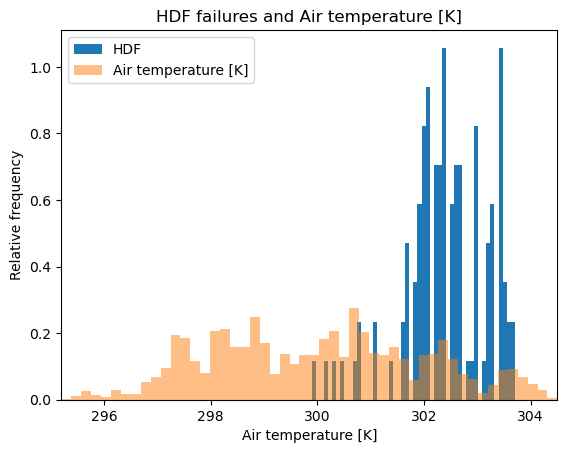

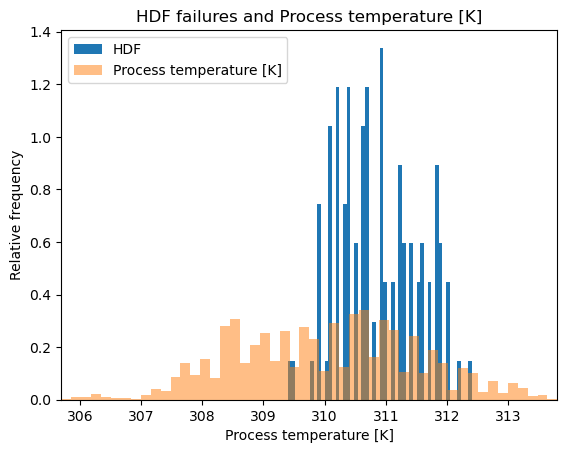

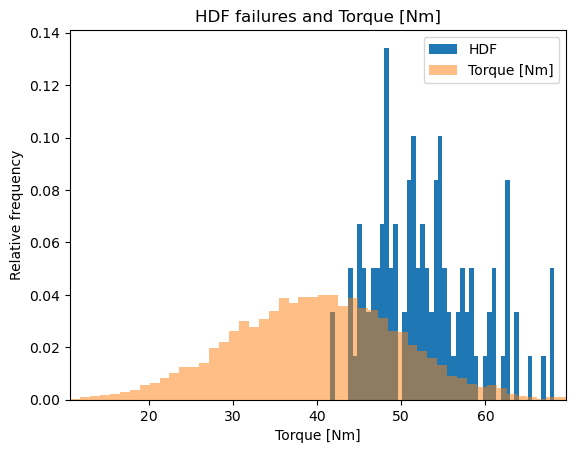

In [18]:
du.DataAnalysis.failure_over_column_range(df, 'HDF', 'Air temperature [K]')
du.DataAnalysis.failure_over_column_range(df, 'HDF', 'Process temperature [K]')
du.DataAnalysis.failure_over_column_range(df, 'HDF', 'Torque [Nm]')


From the first two graphs we can see that HDF happens for Air temperatures between 300 K and 304 K and Process temperatures between 309.5 K and 312.5 K. It would be best to keep Air temperature less than 300 K and the Process temperature less than 309.5 K. From the third graph we can see that Torque needs to be less than 42 Nm.

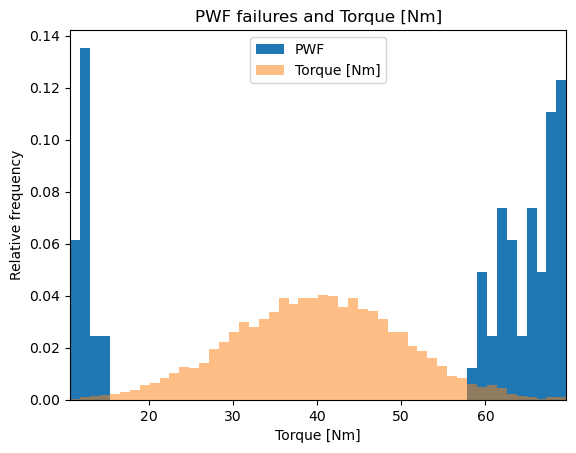

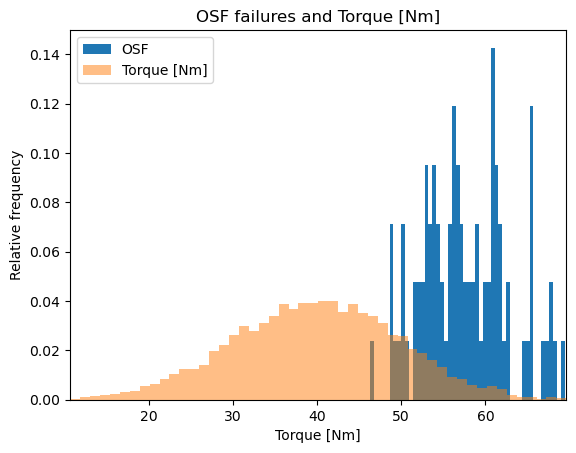

In [19]:
du.DataAnalysis.failure_over_column_range(df, 'PWF', 'Torque [Nm]')
du.DataAnalysis.failure_over_column_range(df, 'OSF', 'Torque [Nm]')

From the first graph, we can see that PWF happens at the extreme values of Torque. Torque must be between 10 Nm and 58 Nm to avoid PWF. To avoid OSF, Torque must be less than 46 Nm.

Altogether, Torque needs to be between 10 Nm and 42 Nm to avoid HDF, PWF and OSF.

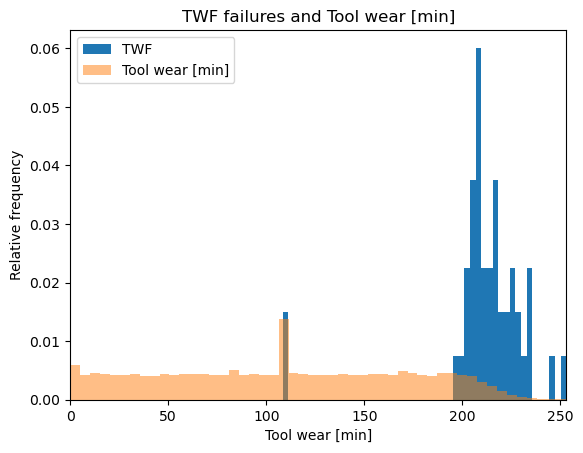

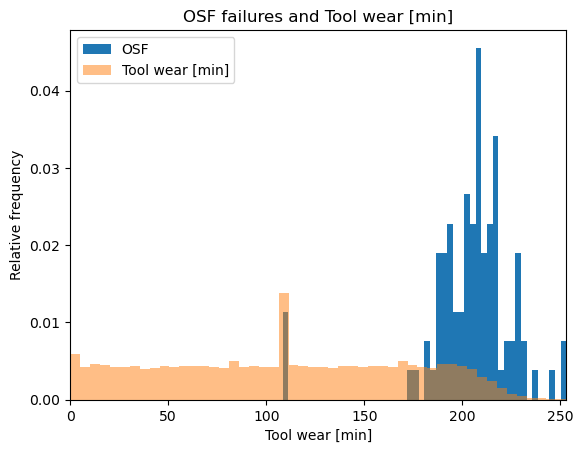

In [20]:
du.DataAnalysis.failure_over_column_range(df, 'TWF', 'Tool wear [min]')
du.DataAnalysis.failure_over_column_range(df, 'OSF', 'Tool wear [min]')

Tool wear must be kept below 175 min to prevent both TWF and OSF. The outlier values of TWF and OSF around 110 min are due to imputation of missing values of 'Tool wear [min]' with the mean value, so these points are unreliable to draw conclusions from.

Altogether, we have the following conclusions: 
- Torque must be kept between 10 Nm and 42 Nm to prevent HDF, PWF and OSF
- Tool wear must be below 175 min to prevent TWF and OSF.
- Air temperature should be kept below 300 K to prevent HDF.
- Process temperature should be kept below 309.5 K to prevent HDF.